Problem 3 - Image classification using Lenet and VGG16

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from imutils import paths # dùng để xử lý ảnh
from sklearn.metrics import classification_report , confusion_matrix
# -> dùng để đánh giá hiệu suất của mô hình
# classification_report : precision , recall , F1 - score , support
# confusion_matrix : ma trận nhầm lẫn để xem mô hình dự đoán đúng sai ở đâu

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model


In [4]:
path = "/content/save_model"
os.mkdir(path)

In [5]:
!pip install GitPython
from git import Repo

In [6]:
filepath = 'temp_concrete_crack'
Repo.clone_from('https://github.com/bimewok/Concrete-Crack-Image-Classifier', filepath)

<git.repo.base.Repo '/content/temp_concrete_crack/.git'>

In [7]:
base_dir = '/content/temp_concrete_crack/data/concrete_images'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

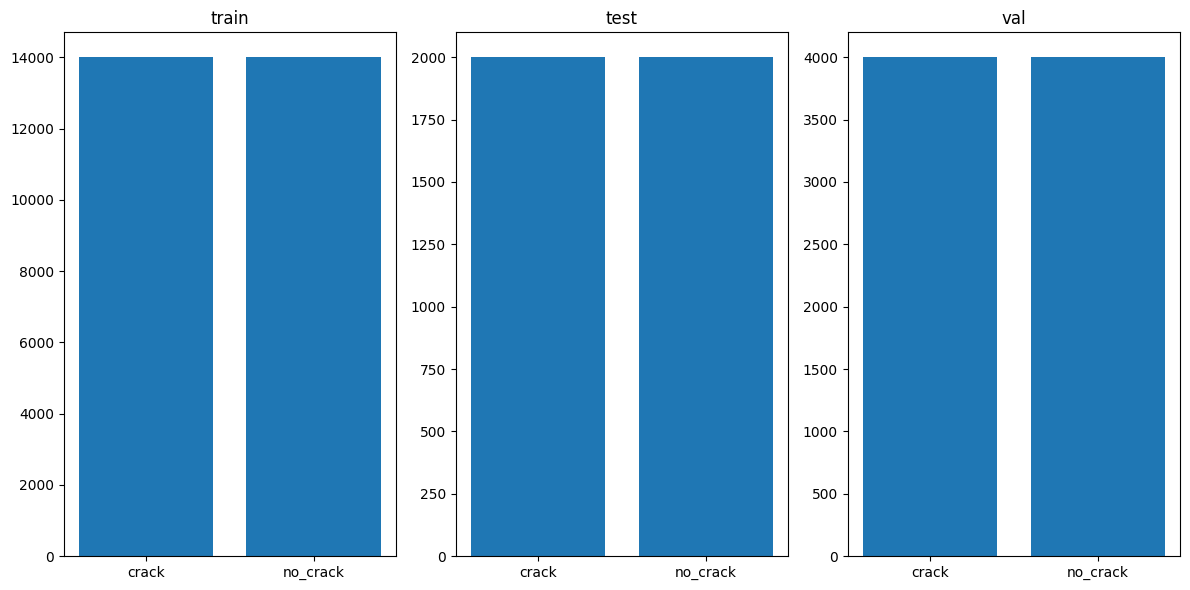

In [8]:
def show_labels(data_dir):
    data = os.listdir(data_dir)
    fig, ax = plt.subplots(1, len(data), figsize=(12,6))
    for idx in range(len(data)):
        sub_dir = os.path.join(data_dir, data[idx])
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(data[idx])
        # ax[idx].axis('off')
    plt.tight_layout()
    plt.show()

show_labels(base_dir)

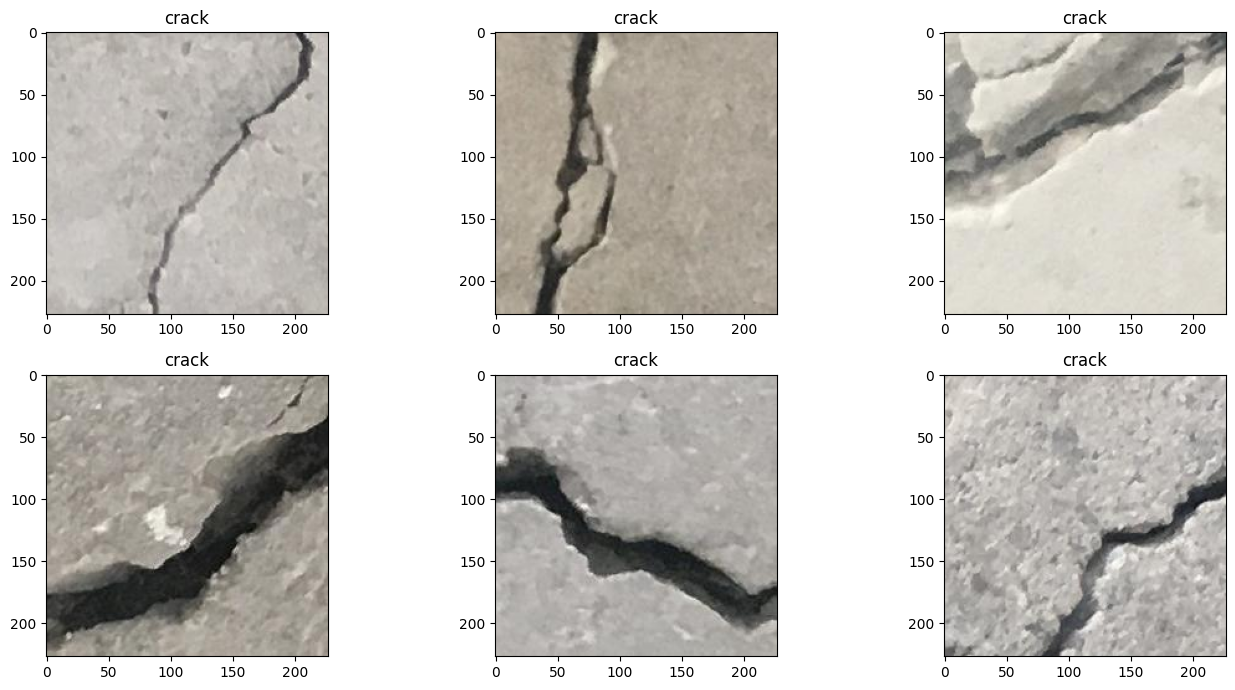

In [9]:
def plot_images(data_dir, label, num_sample=6):
    data_dir = os.path.join(data_dir, label)
    image_files = list(paths.list_images(data_dir))[:num_sample]
    fig, ax = plt.subplots(2,num_sample//2, figsize=(14,7))
    for i, image_dir in enumerate(image_files):
        img = mpimg.imread(image_dir)
        ax[i//(num_sample//2)][i%(num_sample//2)].imshow(img)
        ax[i//(num_sample//2)][i%(num_sample//2)].set_title(label)
    plt.tight_layout()
    plt.show()

plot_images(train_dir, label="crack")

preprocessing

In [10]:
img_size = 150
output_size = 1 # dùng hàm sigmoid
batch_size = 256

train_datagen = ImageDataGenerator( rescale=1.0/255.0,
                                    rotation_range=30,
                                    zoom_range=0.15,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.15,
                                    horizontal_flip=True,
                                    fill_mode="nearest" )

val_datagen = ImageDataGenerator( rescale=1.0/255.0 )
test_datagen = ImageDataGenerator( rescale=1.0/255.0 )
# chuẩn bị quá trình lặp
train_dataloader = train_datagen.flow_from_directory(train_dir,
                                                     class_mode='binary',
                                                     batch_size=batch_size,
                                                     target_size=(img_size, img_size))

valid_dataloader = val_datagen.flow_from_directory(valid_dir,
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(img_size, img_size))

test_dataloader = test_datagen.flow_from_directory(test_dir,
                                           class_mode='binary',
                                           batch_size=batch_size,
                                           target_size=(img_size, img_size))
# tự động nạp dữ liệu theo batch
# gán nhãn


Found 28000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


Model Lenet

In [11]:

lenet_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(img_size, img_size, 3)),

    # S2: Average Pooling layer
    tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=2),

    # C3: Conv layer with 16 filters, kernel size 5x5
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),

    # S4: Average Pooling layer
    tf.keras.layers.AvgPool2D(pool_size=(2, 2), strides=2),

    # Flatten before going into dense layers
    tf.keras.layers.Flatten(),

    # C5: Fully connected layer with 120 units
    tf.keras.layers.Dense(units=120, activation='relu'),

    # F6: Fully connected layer with 84 units
    tf.keras.layers.Dense(units=84, activation='relu'),

    # Output layer: 1 unit (e.g., for binary classification)
    tf.keras.layers.Dense(units=1, activation='sigmoid')  # or 'softmax' for multi-class
])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 73, 73, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 34, 34, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     2,219,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,232,761 (8.52 MB)

 Trainable params: 2,232,761 (8.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lenet_model.compile (optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])
lenet_model.summary()

num_epochs = 10

checkpoint_path = "/content/save_model/lenet_concrete_crack.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            verbose=1,
            save_weights_only=True,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

history = lenet_model.fit(train_dataloader,
                        epochs = num_epochs,
                        validation_data = valid_dataloader,
                        callbacks=[model_checkpoint, learning_rate_reduction])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 73, 73, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 34, 34, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 120)            │     2,219,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,232,761 (8.52 MB)

 Trainable params: 2,232,761 (8.52 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7596 - loss: 0.4851
Epoch 1: val_accuracy improved from -inf to 0.98150, saving model to /content/save_model/lenet_concrete_crack.weights.h5
110/110 ━━━━━━━━━━━━━━━━━━━━ 721s 7s/step - accuracy: 0.7607 - loss: 0.4831 - val_accuracy: 0.9815 - val_loss: 0.0571 - learning_rate: 0.0010
Epoch 2/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9792 - loss: 0.0627
Epoch 2: val_accuracy improved from 0.98150 to 0.98612, saving model to /content/save_model/lenet_concrete_crack.weights.h5
110/110 ━━━━━━━━━━━━━━━━━━━━ 711s 6s/step - accuracy: 0.9792 - loss: 0.0627 - val_accuracy: 0.9861 - val_loss: 0.0442 - learning_rate: 0.0010
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9831 - loss: 0.0552
Epoch 3: val_accuracy did not improve from 0.98612
110/110 ━━━━━━━━━━━━━━━━━━━━ 711s 6s/step - accuracy: 0.9831 - loss: 0.0551 - val_accuracy: 0.9854 - val_loss: 0.0460 - learning_rate: 0.0010
Epoch 4/10
110/110 ━━━━

In [ ]:
lenet_model.load_weights("/content/save_model/lenet_concrete_crack.weights.h5")
loss, accuracy = lenet_model.evaluate(test_dataloader, steps=len(test_dataloader), verbose=1)

In [ ]:
lenet_model.save ("save_model/concrete_crack_model.h5")

FastAPI

In [ ]:
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from tensorflow.keras.models import load_model
import numpy as np
import cv2
import io

app = FastAPI()
model = load_model('save_model/concrete_crack_model.h5')  # đường dẫn đến file model của bạn

def preprocess_image(image_bytes):
    image = np.frombuffer(image_bytes, np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (150, 150 ,3))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    contents = await file.read()
    image = preprocess_image(contents)
    prediction = model.predict(image)[0][0]

    result = "Cracked" if prediction > 0.5 else "Uncracked"
    confidence = float(prediction if prediction > 0.5 else 1 - prediction)

    return JSONResponse({
        "prediction": result,
        "confidence": confidence
    })
